### **Setup and imports**


In [5]:
!pip install xgboost catboost shap optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 41.0 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE

import optuna
from optuna.samplers import TPESampler



RANDOM_STATE = 42

# Loading the dataset

In [8]:
data = pd.read_excel('/content/finaldata(1).csv.xlsx')
from sklearn.neighbors import NearestNeighbors

data = data.drop(columns=["S. No."])
data['Liver Healthy'] = data['Liver Healthy'].map({'Yes': 1, 'No': 0, 'Mid' : 1}).astype(int)

df_features = data.drop(columns=["Liver Healthy"])
df_labels = data["Liver Healthy"]

# Dataset A: Noise-Augmented with varied noise distributions
def generate_dataset_with_noise_improved(df, labels, n_samples=100, noise_level_numeric=0.05, noise_level_categorical=0.01):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(exclude=[np.number]).columns
    new_data = []
    new_labels = []
    for _ in range(n_samples):
        idx = np.random.randint(0, len(df))
        row = df.iloc[idx].copy()
        label = labels.iloc[idx]

        for col in numeric_cols:
            noise_type = np.random.choice(['normal', 'uniform'])
            if noise_type == 'normal':
                noise = np.random.normal(0, noise_level_numeric * df[col].std())
            else:
                noise = np.random.uniform(-noise_level_numeric * df[col].std(), noise_level_numeric * df[col].std())
            row[col] += noise
            if col == "Age":
                row[col] = int(round(row[col]))
        # Add noise to categorical features (randomly flip a small percentage)
        for col in cat_cols:
            if np.random.rand() < noise_level_categorical:
                unique_values = df[col].unique()
                row[col] = np.random.choice(unique_values)
        # Ensure numeric values stay within original range
        for col in numeric_cols:
            row[col] = np.clip(row[col], df[col].min(), df[col].max())
        new_data.append(row)
        new_labels.append(label)
    df_aug = pd.DataFrame(new_data)
    df_aug['Liver Healthy'] = new_labels
    return df_aug

# Dataset B: Class-wise Statistical Sampling with added randomness
def generate_dataset_statistical_improved(df, labels, n_samples=100):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(exclude=[np.number]).columns
    df_0 = df[labels == 0]
    df_1 = df[labels == 1]
    data_gen = []
    labels_gen = []
    for _ in range(n_samples):
        label = np.random.choice([0, 1])
        source_df = df_0 if label == 0 else df_1
        new_row = {}
        for col in numeric_cols:
            mu = source_df[col].mean()
            sigma = source_df[col].std()
            val = np.random.normal(mu, sigma) * np.random.uniform(0.8, 1.2)
            val = np.clip(val, df[col].min(), df[col].max())
            new_row[col] = int(round(val)) if col == "Age" else val
        for col in cat_cols:
             if not source_df[col].empty:
                new_row[col] = source_df[col].sample(n=1, replace=True).values[0]
             else:
                new_row[col] = df[col].sample(n=1, replace=True).values[0]
        data_gen.append(new_row)
        labels_gen.append(label)
    df_generated = pd.DataFrame(data_gen)
    df_generated['Liver Healthy'] = labels_gen
    return df_generated

# Dataset C: SMOTE-like Interpolation with extrapolation
def generate_dataset_interpolation_extrapolation(df, labels, n_samples=100, k=3, extrapolation_factor=0.2):
    numeric_df = df.select_dtypes(include=[np.number])
    categorical_df = df.select_dtypes(exclude=[np.number])
    new_data = []
    new_labels = []
    for label in [0, 1]:
        df_label = numeric_df[labels == label].reset_index(drop=True)
        cats_label = categorical_df[labels == label].reset_index(drop=True)
        if len(df_label) > k:
            nbrs = NearestNeighbors(n_neighbors=k+1).fit(df_label)
            for _ in range(n_samples // 2):
                idx = np.random.randint(0, len(df_label))
                _, indices = nbrs.kneighbors([df_label.iloc[idx]])
                neighbor_idx = np.random.choice(indices[0][1:])
                row1 = df_label.iloc[idx]
                row2 = df_label.iloc[neighbor_idx]
                alpha = np.random.uniform(-extrapolation_factor, 1 + extrapolation_factor)
                interp_row = row1 + alpha * (row2 - row1)
                interp_row["Age"] = int(round(interp_row["Age"]))
                for col in numeric_df.columns:
                    interp_row[col] = np.clip(interp_row[col], df[col].min(), df[col].max())
                cat_row = cats_label.iloc[idx].copy()
                combined = pd.concat([interp_row, cat_row])
                new_data.append(combined)
                new_labels.append(label)
        else:
            for _ in range(n_samples // 2):
                idx = np.random.randint(0, len(df_label))
                combined = pd.concat([df_label.iloc[idx], cats_label.iloc[idx]])
                new_data.append(combined)
                new_labels.append(label)


    df_interp = pd.DataFrame(new_data)
    df_interp['Liver Healthy'] = new_labels
    return df_interp

dataset_a = generate_dataset_with_noise_improved(df_features, df_labels, n_samples=250)
dataset_b = generate_dataset_statistical_improved(df_features, df_labels, n_samples=250)
dataset_c = generate_dataset_interpolation_extrapolation(df_features, df_labels, n_samples=250)

df = pd.concat([data, dataset_a, dataset_b, dataset_c], ignore_index=True)

print(df.describe())
print(df.info())
print(df.head())

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/

              Age            R            G            B            C  \
count  881.000000   881.000000   881.000000   881.000000   881.000000   
mean    29.736663   809.280166   540.578775   347.071896  1732.589669   
std     14.858763   505.706988   350.080607   225.564446  1055.927138   
min     19.000000    82.290000    46.570000    33.000000   155.860000   
25%     20.000000   361.123429   211.761113   144.536424   773.285697   
50%     23.000000   793.186230   509.754187   318.620946  1666.009416   
75%     33.000000  1135.673277   818.000000   521.417689  2566.417588   
max     85.000000  2058.830000  1554.290000  1095.860000  4302.710000   

        Temp90614   Temp90640          GSR         BMI  Liver Healthy  
count  881.000000  881.000000   881.000000  881.000000     881.000000  
mean    31.104797   34.194364   456.832077   24.741864       0.549376  
std      3.339921    3.304935   342.647271    4.550731       0.497839  
min     22.170000   25.840000    43.140000   14.490000

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/

# Yellowness Index


In [9]:
R, G, B, C = df["R"].astype(float), df["G"].astype(float), df["B"].astype(float), df["C"].astype(float)

rgb = np.stack([R, G, B], axis=1)
C_array = C.to_numpy().reshape(-1, 1)
rgb_norm = rgb / np.clip(C_array, 1e-6, None)

gray_world_avg = np.mean(rgb_norm, axis=0)
rgb_balanced = np.clip(rgb_norm / gray_world_avg, 0, 1)

gamma = 2.2
rgb_linear = np.power(rgb_balanced, gamma)

M_sRGB_D65 = np.array([
    [0.4124564, 0.3575761, 0.1804375],
    [0.2126729, 0.7151522, 0.0721750],
    [0.0193339, 0.1191920, 0.9503041]
])
xyz = rgb_linear @ M_sRGB_D65.T
X, Y, Z = xyz[:, 0], xyz[:, 1], xyz[:, 2]

scaler_xyz = RobustScaler()
X_scaled, Y_scaled, Z_scaled = scaler_xyz.fit_transform(np.stack([X, Y, Z], axis=1)).T

Cx, Cz = 1.2769, 1.0592
YI_raw = 100 * (Cx * X_scaled - Cz * Z_scaled) / np.clip(Y_scaled, 1e-6, None)
df["Yellowness Index"] = (YI_raw - YI_raw.min()) / (YI_raw.max() - YI_raw.min())

df.drop(["R", "G", "B", "C"], axis=1, inplace=True)

# Encoding

In [10]:
df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0}).astype(float)
df.rename(columns={"Temp90614": "BodyTemp", "Temp90640": "LiverTemp"}, inplace=True)

print("\nClass Distribution:")
print(df["Liver Healthy"].value_counts(normalize=True))

X = df.drop(["Liver Healthy"], axis=1)
y = df["Liver Healthy"]


Class Distribution:
Liver Healthy
1    0.549376
0    0.450624
Name: proportion, dtype: float64


# **Train-Test Split**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Correlation Matrix**

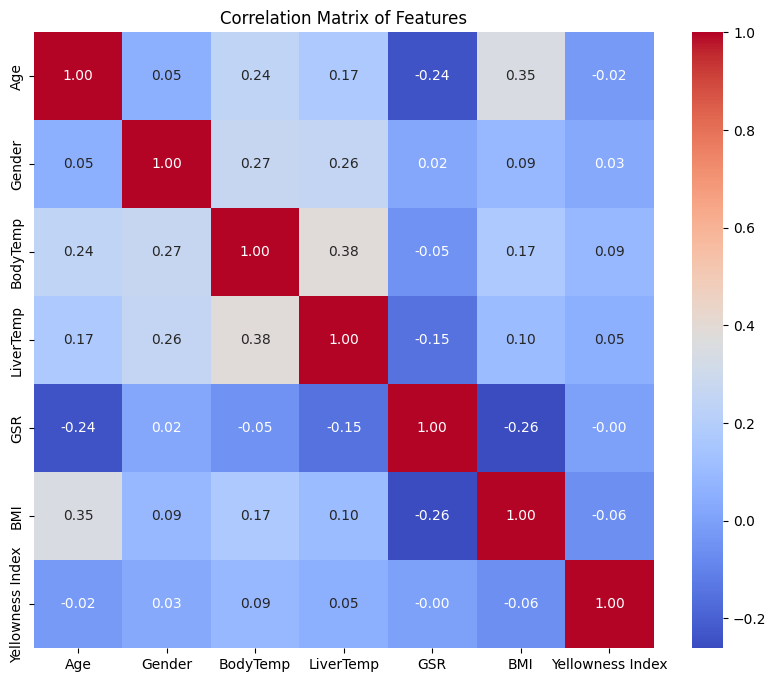

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(X).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Features")
plt.show()

# Hyperparameter Tuning:

In [13]:
# Make sure these are imported
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# Optional: ensure xgboost & catboost are installed
# !pip install xgboost catboost

def tune_model(trial, model_name):
    if model_name == "RandomForest":
        return RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 300),
            max_depth=trial.suggest_int("max_depth", 3, 15),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 4),
            class_weight="balanced",
            random_state=RANDOM_STATE,
            n_jobs=-1
        )

    elif model_name == "LogisticRegression":
        return LogisticRegression(
            C=trial.suggest_float("C", 0.001, 10, log=True),
            penalty="l2",
            solver="lbfgs",
            max_iter=1000,
            class_weight="balanced",
        )

    elif model_name == "SVM_RBF":
        return SVC(
            kernel="rbf",
            C=trial.suggest_float("C", 0.1, 10, log=True),
            gamma=trial.suggest_categorical("gamma", ["scale", "auto"]),
            probability=True,
            class_weight="balanced",
        )

    elif model_name == "SVM_Poly":
        return SVC(
            kernel="poly",
            C=trial.suggest_float("C", 0.1, 10, log=True),
            degree=trial.suggest_int("degree", 2, 4),
            probability=True,
            class_weight="balanced",
        )

    elif model_name == "XGBoost":
        return XGBClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 300),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            max_depth=trial.suggest_int("max_depth", 3, 8),
            subsample=trial.suggest_float("subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
            eval_metric="logloss",
            random_state=RANDOM_STATE,
            n_jobs=-1
        )

    elif model_name == "CatBoost":
        return CatBoostClassifier(
            iterations=trial.suggest_int("iterations", 100, 300),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            depth=trial.suggest_int("depth", 4, 8),
            verbose=0,
            random_state=RANDOM_STATE
        )

def objective(trial, model_name):
    model = tune_model(trial, model_name)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr = X_train.iloc[train_idx] if hasattr(X_train, "iloc") else X_train[train_idx]
        X_val = X_train.iloc[val_idx] if hasattr(X_train, "iloc") else X_train[val_idx]

        y_tr = y_train.iloc[train_idx] if hasattr(y_train, "iloc") else y_train[train_idx]
        y_val = y_train.iloc[val_idx] if hasattr(y_train, "iloc") else y_train[val_idx]

        model.fit(X_tr, y_tr)
        y_proba = model.predict_proba(X_val)[:, 1]
        scores.append(roc_auc_score(y_val, y_proba))

    return float(np.nanmean(scores))

models_to_tune = ["RandomForest", "LogisticRegression", "SVM_RBF", "SVM_Poly", "XGBoost", "CatBoost"]
best_estimators = {}

for model_name in models_to_tune:
    print(f"\nTuning {model_name}...")
    study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=RANDOM_STATE))

    # Reduce trials for Colab demo speed (increase later)
    study.optimize(lambda trial: objective(trial, model_name), n_trials=10, show_progress_bar=True)

    best_model = tune_model(study.best_trial, model_name)
    best_model.fit(X_train, y_train)
    best_estimators[model_name] = best_model

print("Tuning completed. Models trained:", list(best_estimators.keys()))


[I 2026-02-07 12:17:32,489] A new study created in memory with name: no-name-3ef5ad07-c0c3-4cc5-861b-b167a8c058ed



Tuning RandomForest...


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-02-07 12:17:33,598] Trial 0 finished with value: 0.9798249951826081 and parameters: {'n_estimators': 175, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9798249951826081.
[I 2026-02-07 12:17:34,427] Trial 1 finished with value: 0.9766441235945406 and parameters: {'n_estimators': 131, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9798249951826081.
[I 2026-02-07 12:17:35,784] Trial 2 finished with value: 0.979409190422793 and parameters: {'n_estimators': 220, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9798249951826081.
[I 2026-02-07 12:17:37,387] Trial 3 finished with value: 0.9785274335954458 and parameters: {'n_estimators': 267, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9798249951826081.
[I 2026-02-07 12:17:38,384] Trial 4 finished with value: 0.9818803383085962 and parameters: {'n

[I 2026-02-07 12:17:44,739] A new study created in memory with name: no-name-ba166b62-e7ac-43f6-80eb-6ab9d06817f6



Tuning LogisticRegression...


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-02-07 12:17:44,782] Trial 0 finished with value: 0.9649820885889336 and parameters: {'C': 0.03148911647956861}. Best is trial 0 with value: 0.9649820885889336.
[I 2026-02-07 12:17:44,803] Trial 1 finished with value: 0.9703849966684542 and parameters: {'C': 6.351221010640703}. Best is trial 1 with value: 0.9703849966684542.
[I 2026-02-07 12:17:44,827] Trial 2 finished with value: 0.9701651378702717 and parameters: {'C': 0.8471801418819978}. Best is trial 1 with value: 0.9703849966684542.
[I 2026-02-07 12:17:44,849] Trial 3 finished with value: 0.9693581376775761 and parameters: {'C': 0.24810409748678125}. Best is trial 1 with value: 0.9703849966684542.
[I 2026-02-07 12:17:44,873] Trial 4 finished with value: 0.9563042827193771 and parameters: {'C': 0.004207988669606638}. Best is trial 1 with value: 0.9703849966684542.
[I 2026-02-07 12:17:44,894] Trial 5 finished with value: 0.9563042827193771 and parameters: {'C': 0.004207053950287938}. Best is trial 1 with value: 0.97038499666

[I 2026-02-07 12:17:44,998] A new study created in memory with name: no-name-59c21689-1d52-4e53-9261-dcf9fa318b3a


[I 2026-02-07 12:17:44,986] Trial 9 finished with value: 0.9699696562355623 and parameters: {'C': 0.679657809075816}. Best is trial 1 with value: 0.9703849966684542.

Tuning SVM_RBF...


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-02-07 12:17:45,136] Trial 0 finished with value: 0.9718590024864707 and parameters: {'C': 0.5611516415334505, 'gamma': 'scale'}. Best is trial 0 with value: 0.9718590024864707.
[I 2026-02-07 12:17:45,205] Trial 1 finished with value: 0.9754001917670192 and parameters: {'C': 1.5751320499779735, 'gamma': 'scale'}. Best is trial 1 with value: 0.9754001917670192.
[I 2026-02-07 12:17:45,303] Trial 2 finished with value: 0.9621443545971848 and parameters: {'C': 0.13066739238053282, 'gamma': 'scale'}. Best is trial 1 with value: 0.9754001917670192.
[I 2026-02-07 12:17:45,381] Trial 3 finished with value: 0.974758259795557 and parameters: {'C': 2.607024758370768, 'gamma': 'auto'}. Best is trial 1 with value: 0.9754001917670192.
[I 2026-02-07 12:17:45,442] Trial 4 finished with value: 0.9721714945058517 and parameters: {'C': 4.622589001020832, 'gamma': 'scale'}. Best is trial 1 with value: 0.9754001917670192.
[I 2026-02-07 12:17:45,531] Trial 5 finished with value: 0.967239646090019 and

[I 2026-02-07 12:17:45,892] A new study created in memory with name: no-name-4d16c839-f5aa-46a4-92e7-8e0f91117b8d


[I 2026-02-07 12:17:45,850] Trial 9 finished with value: 0.9741794762856631 and parameters: {'C': 1.0677482709481354, 'gamma': 'scale'}. Best is trial 1 with value: 0.9754001917670192.

Tuning SVM_Poly...


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-02-07 12:17:46,009] Trial 0 finished with value: 0.84252329179929 and parameters: {'C': 0.5611516415334505, 'degree': 4}. Best is trial 0 with value: 0.84252329179929.
[I 2026-02-07 12:17:46,074] Trial 1 finished with value: 0.9664811680608082 and parameters: {'C': 2.9106359131330697, 'degree': 3}. Best is trial 1 with value: 0.9664811680608082.
[I 2026-02-07 12:17:46,172] Trial 2 finished with value: 0.7725009344579332 and parameters: {'C': 0.20513382630874505, 'degree': 2}. Best is trial 1 with value: 0.9664811680608082.
[I 2026-02-07 12:17:46,280] Trial 3 finished with value: 0.8330287348716484 and parameters: {'C': 0.13066739238053282, 'degree': 4}. Best is trial 1 with value: 0.9664811680608082.
[I 2026-02-07 12:17:46,372] Trial 4 finished with value: 0.8479419869942029 and parameters: {'C': 1.5930522616241019, 'degree': 4}. Best is trial 1 with value: 0.9664811680608082.
[I 2026-02-07 12:17:46,477] Trial 5 finished with value: 0.8340546652086802 and parameters: {'C': 0.10

[I 2026-02-07 12:17:46,927] A new study created in memory with name: no-name-bdbd962e-e3c5-4f54-b265-19921fb31924


[I 2026-02-07 12:17:46,877] Trial 9 finished with value: 0.7885481890089174 and parameters: {'C': 0.7309539835912913, 'degree': 2}. Best is trial 8 with value: 0.967429439719918.

Tuning XGBoost...


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-02-07 12:17:47,360] Trial 0 finished with value: 0.9770910382582169 and parameters: {'n_estimators': 175, 'learning_rate': 0.2536999076681772, 'max_depth': 7, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746}. Best is trial 0 with value: 0.9770910382582169.
[I 2026-02-07 12:17:47,651] Trial 1 finished with value: 0.9774580886910855 and parameters: {'n_estimators': 131, 'learning_rate': 0.012184186502221764, 'max_depth': 8, 'subsample': 0.8404460046972835, 'colsample_bytree': 0.8832290311184181}. Best is trial 1 with value: 0.9774580886910855.
[I 2026-02-07 12:17:47,755] Trial 2 finished with value: 0.9753832438343188 and parameters: {'n_estimators': 104, 'learning_rate': 0.2708160864249968, 'max_depth': 7, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402}. Best is trial 1 with value: 0.9774580886910855.
[I 2026-02-07 12:17:47,962] Trial 3 finished with value: 0.9788975021533161 and parameters: {'n_estimators': 136, 'learning_rate': 

[I 2026-02-07 12:17:49,489] A new study created in memory with name: no-name-3d370e4e-41ac-4315-bc3b-280e5c608194


[I 2026-02-07 12:17:49,359] Trial 9 finished with value: 0.9791712228746016 and parameters: {'n_estimators': 233, 'learning_rate': 0.028869220380495747, 'max_depth': 6, 'subsample': 0.8186841117373118, 'colsample_bytree': 0.6739417822102108}. Best is trial 5 with value: 0.9798073507595227.

Tuning CatBoost...


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-02-07 12:17:50,681] Trial 0 finished with value: 0.9830397626360768 and parameters: {'iterations': 175, 'learning_rate': 0.2536999076681772, 'depth': 7}. Best is trial 0 with value: 0.9830397626360768.
[I 2026-02-07 12:17:51,273] Trial 1 finished with value: 0.9800158335480846 and parameters: {'iterations': 220, 'learning_rate': 0.01700037298921102, 'depth': 4}. Best is trial 0 with value: 0.9830397626360768.
[I 2026-02-07 12:17:52,010] Trial 2 finished with value: 0.9826422987897319 and parameters: {'iterations': 111, 'learning_rate': 0.19030368381735815, 'depth': 7}. Best is trial 0 with value: 0.9830397626360768.
[I 2026-02-07 12:17:55,180] Trial 3 finished with value: 0.9826381198474222 and parameters: {'iterations': 242, 'learning_rate': 0.010725209743171997, 'depth': 8}. Best is trial 0 with value: 0.9830397626360768.
[I 2026-02-07 12:17:56,669] Trial 4 finished with value: 0.9819504516740145 and parameters: {'iterations': 267, 'learning_rate': 0.020589728197687916, 'dept

# Evaluation **parameters** (model-wise)


Evaluation of RandomForest
              precision    recall  f1-score   support

           0       0.99      0.89      0.93        80
           1       0.91      0.99      0.95        97

    accuracy                           0.94       177
   macro avg       0.95      0.94      0.94       177
weighted avg       0.95      0.94      0.94       177

ROC-AUC: 0.9845


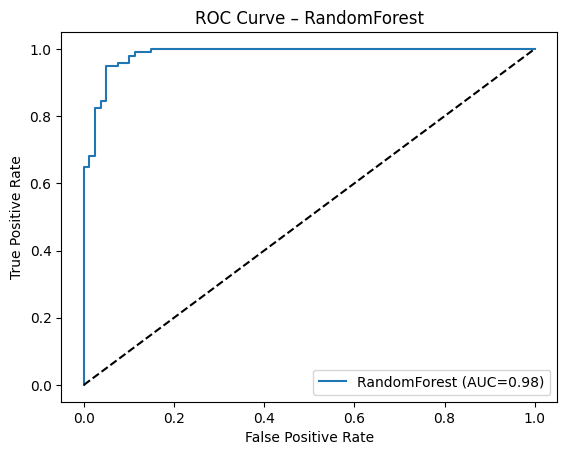


Evaluation of LogisticRegression
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        80
           1       0.90      0.95      0.92        97

    accuracy                           0.92       177
   macro avg       0.92      0.91      0.91       177
weighted avg       0.92      0.92      0.91       177

ROC-AUC: 0.9554


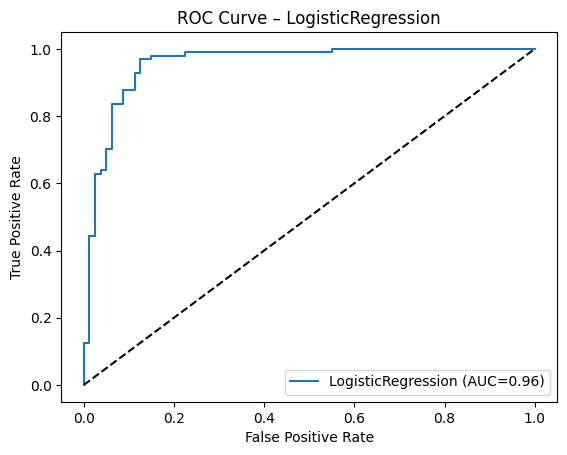


Evaluation of SVM_RBF
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        80
           1       0.88      0.96      0.92        97

    accuracy                           0.90       177
   macro avg       0.91      0.90      0.90       177
weighted avg       0.91      0.90      0.90       177

ROC-AUC: 0.9677


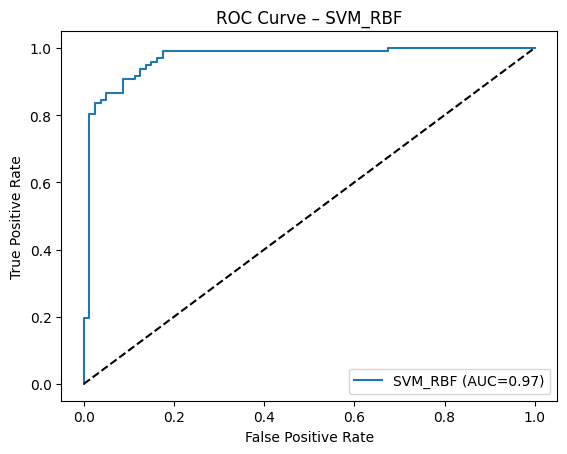


Evaluation of SVM_Poly
              precision    recall  f1-score   support

           0       0.94      0.80      0.86        80
           1       0.85      0.96      0.90        97

    accuracy                           0.89       177
   macro avg       0.90      0.88      0.88       177
weighted avg       0.89      0.89      0.89       177

ROC-AUC: 0.9330


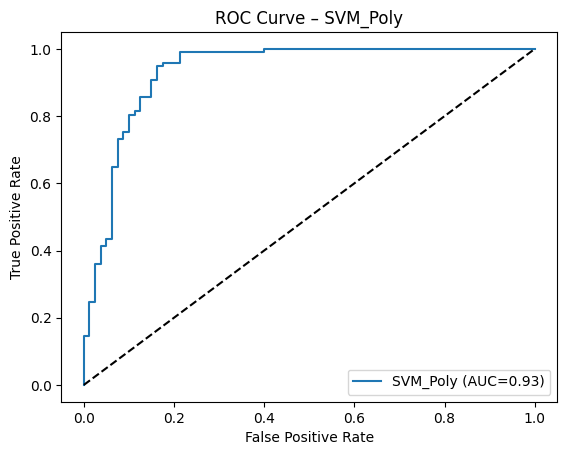


Evaluation of XGBoost
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        80
           1       0.91      0.98      0.95        97

    accuracy                           0.94       177
   macro avg       0.94      0.93      0.94       177
weighted avg       0.94      0.94      0.94       177

ROC-AUC: 0.9785


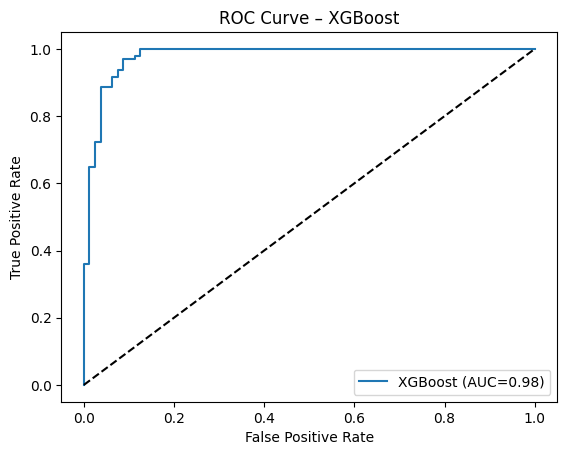


Evaluation of CatBoost
              precision    recall  f1-score   support

           0       0.97      0.88      0.92        80
           1       0.90      0.98      0.94        97

    accuracy                           0.93       177
   macro avg       0.94      0.93      0.93       177
weighted avg       0.94      0.93      0.93       177

ROC-AUC: 0.9731


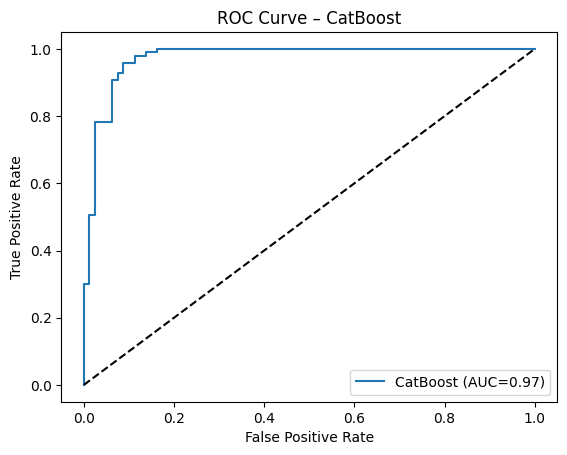

In [14]:
for name, model in best_estimators.items():
    print(f"\nEvaluation of {name}")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {auc:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {name}")
    plt.legend()
    plt.show()

# Ensembling


✅ Stacked Model Classification Report
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        80
           1       0.91      0.98      0.95        97

    accuracy                           0.94       177
   macro avg       0.94      0.93      0.94       177
weighted avg       0.94      0.94      0.94       177

Stacked Model ROC-AUC: 0.9812


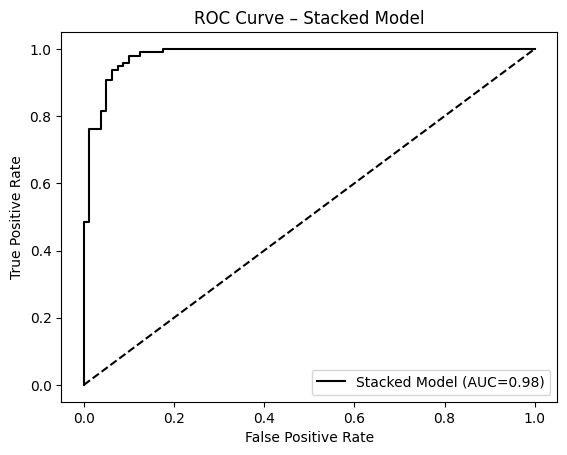


✅ Voting Classifier Classification Report
              precision    recall  f1-score   support

           0       0.97      0.88      0.92        80
           1       0.90      0.98      0.94        97

    accuracy                           0.93       177
   macro avg       0.94      0.93      0.93       177
weighted avg       0.94      0.93      0.93       177

Voting Classifier ROC-AUC: 0.9782


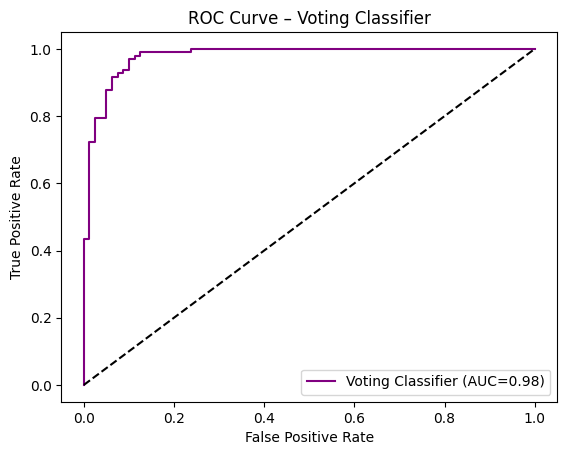

In [15]:
# Stacking
stack_estimators = [
    ("xgb", best_estimators["XGBoost"]),
    ("cat", best_estimators["CatBoost"]),
    ("rf", best_estimators["RandomForest"]),
    ("svm_rbf", best_estimators["SVM_RBF"]),
    ("svm_poly", best_estimators["SVM_Poly"]),
]
stacked_model = StackingClassifier(
    estimators=stack_estimators,
    final_estimator=LogisticRegression(max_iter=1000)
)
stacked_model.fit(X_train, y_train)

y_pred_stack = stacked_model.predict(X_test)
y_proba_stack = stacked_model.predict_proba(X_test)[:, 1]
print("\n✅ Stacked Model Classification Report")
print(classification_report(y_test, y_pred_stack))
stack_auc = roc_auc_score(y_test, y_proba_stack)
print(f"Stacked Model ROC-AUC: {stack_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba_stack)
plt.figure()
plt.plot(fpr, tpr, label=f"Stacked Model (AUC={stack_auc:.2f})", color="black")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Stacked Model")
plt.legend()
plt.show()

# Voting (Soft Voting)
voting_model = VotingClassifier(
    estimators=stack_estimators,
    voting="soft"
)
voting_model.fit(X_train, y_train)

y_pred_vote = voting_model.predict(X_test)
y_proba_vote = voting_model.predict_proba(X_test)[:, 1]
print("\n✅ Voting Classifier Classification Report")
print(classification_report(y_test, y_pred_vote))
vote_auc = roc_auc_score(y_test, y_proba_vote)
print(f"Voting Classifier ROC-AUC: {vote_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba_vote)
plt.figure()
plt.plot(fpr, tpr, label=f"Voting Classifier (AUC={vote_auc:.2f})", color="purple")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Voting Classifier")
plt.legend()
plt.show()

# Feature Importance & SHAP


🔍 Feature Importance – RandomForest


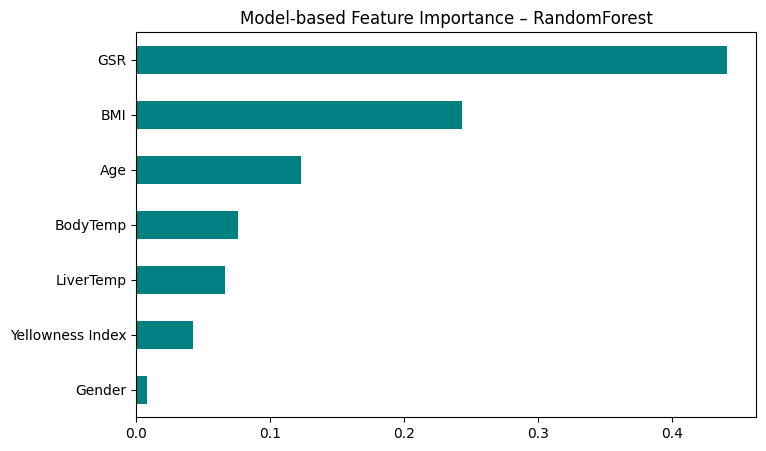

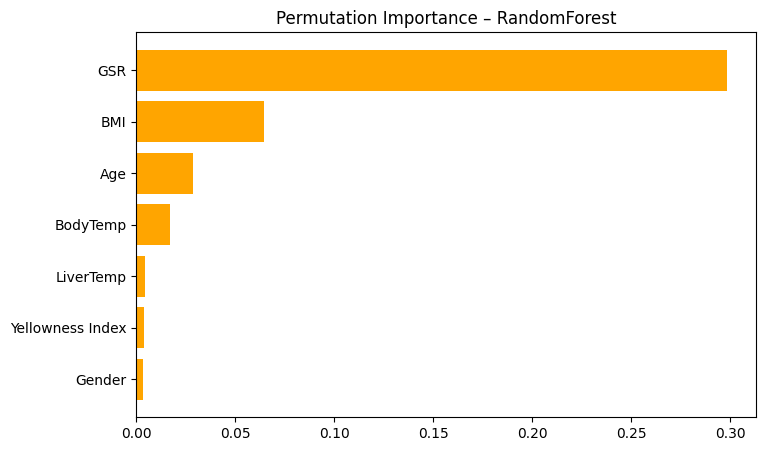

Generating SHAP for RandomForest...


ExactExplainer explainer: 178it [00:27,  5.19it/s]


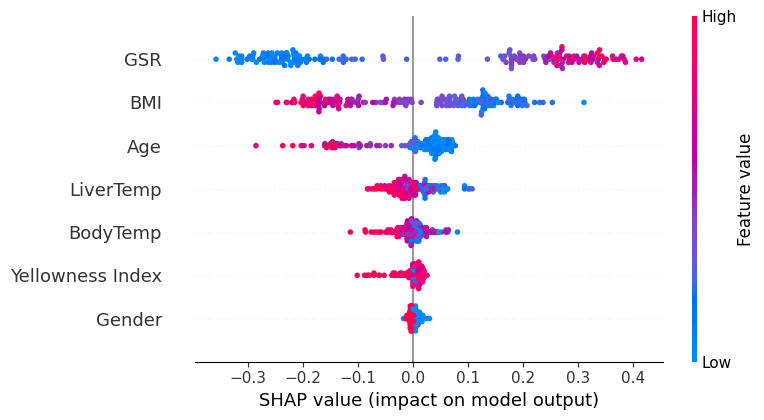


🔍 Feature Importance – LogisticRegression


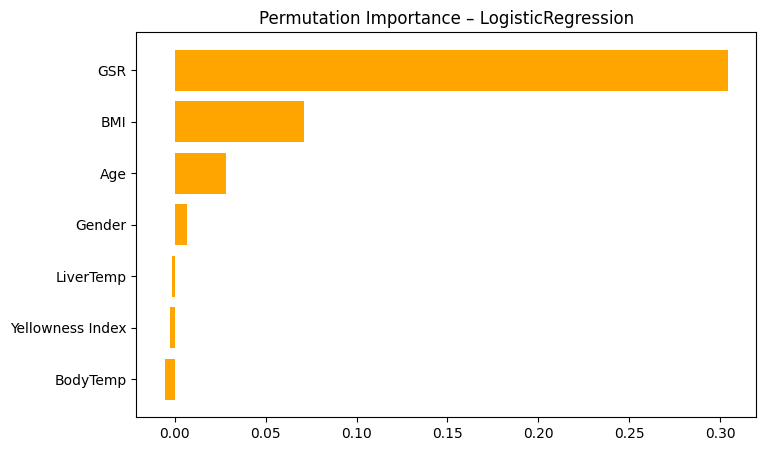

Generating SHAP for LogisticRegression...


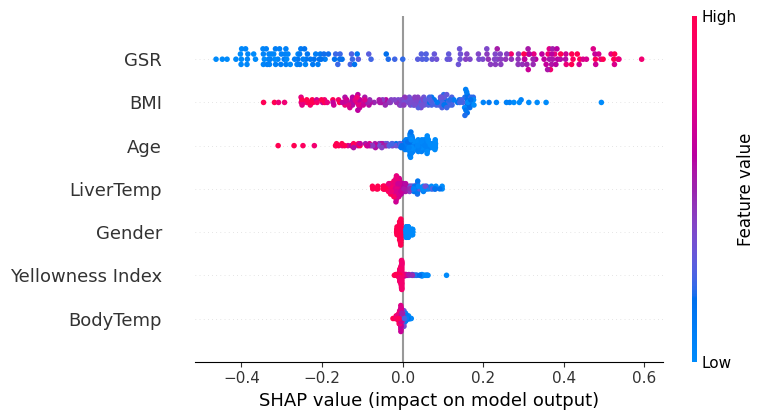


🔍 Feature Importance – SVM_RBF


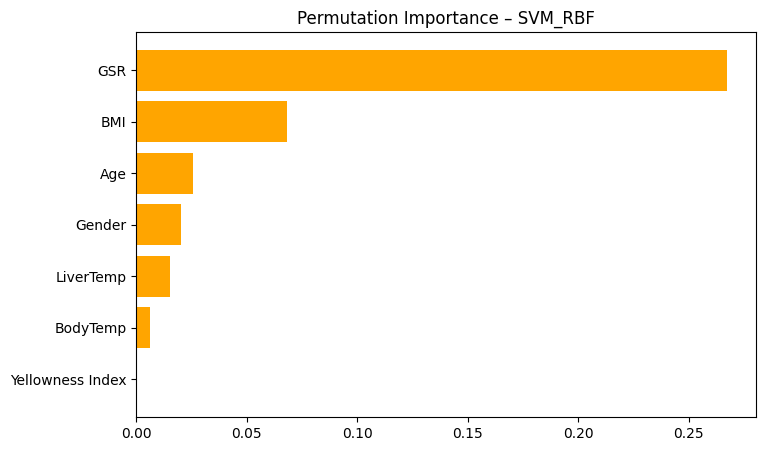

Generating SHAP for SVM_RBF...


ExactExplainer explainer: 178it [00:22,  4.39it/s]


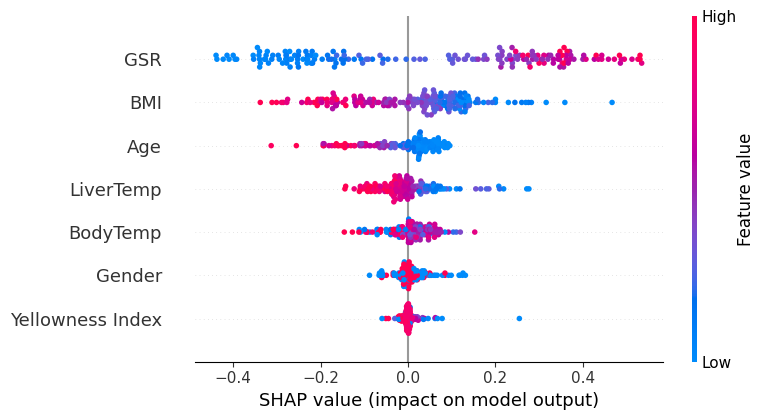


🔍 Feature Importance – SVM_Poly


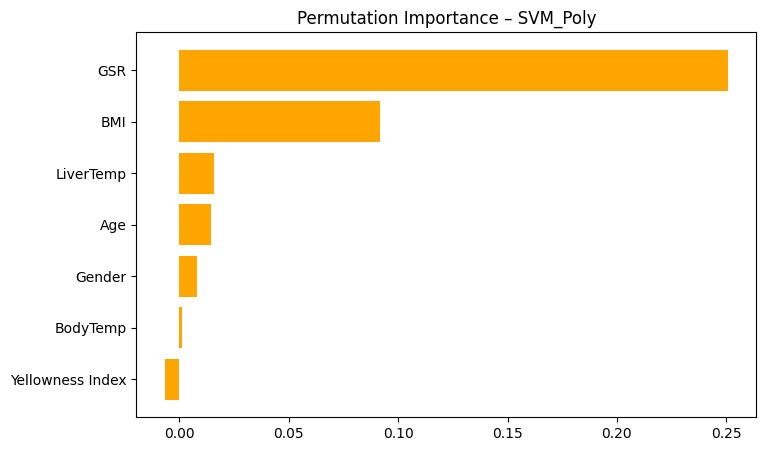

Generating SHAP for SVM_Poly...


ExactExplainer explainer: 178it [00:20,  4.48it/s]


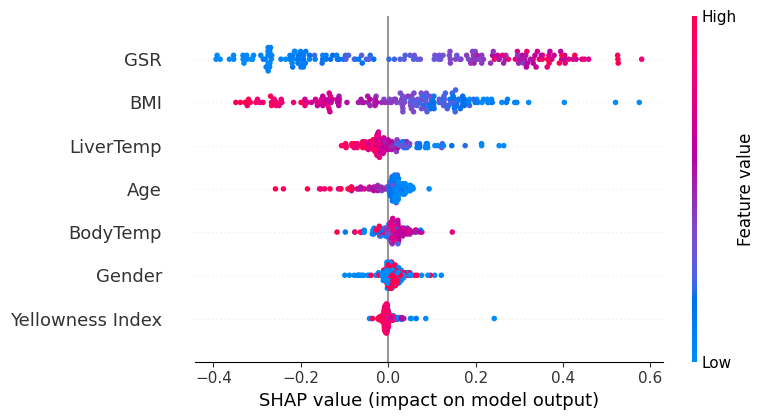


🔍 Feature Importance – XGBoost


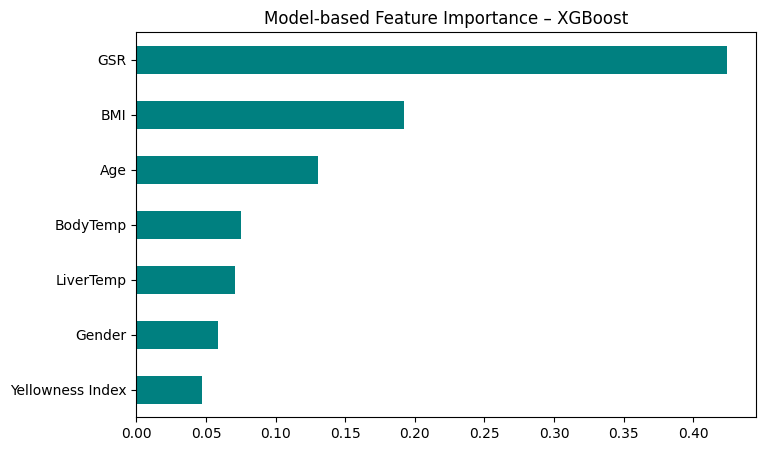

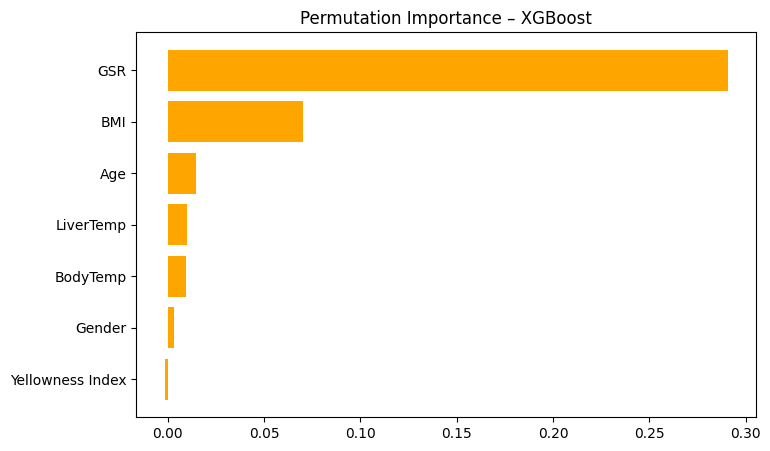

Generating SHAP for XGBoost...


ExactExplainer explainer: 178it [00:14,  4.01it/s]


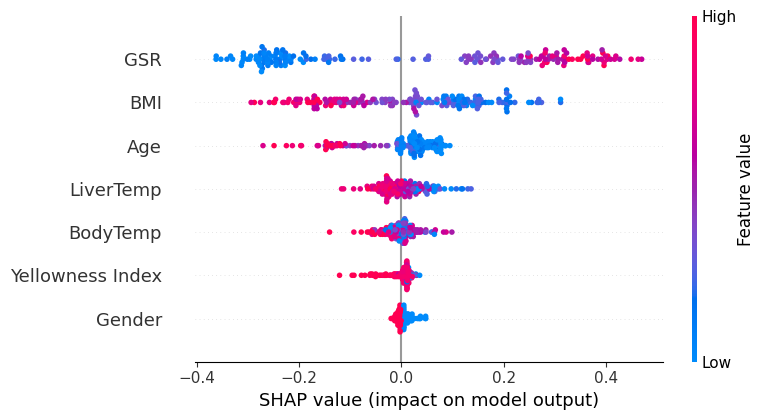


🔍 Feature Importance – CatBoost


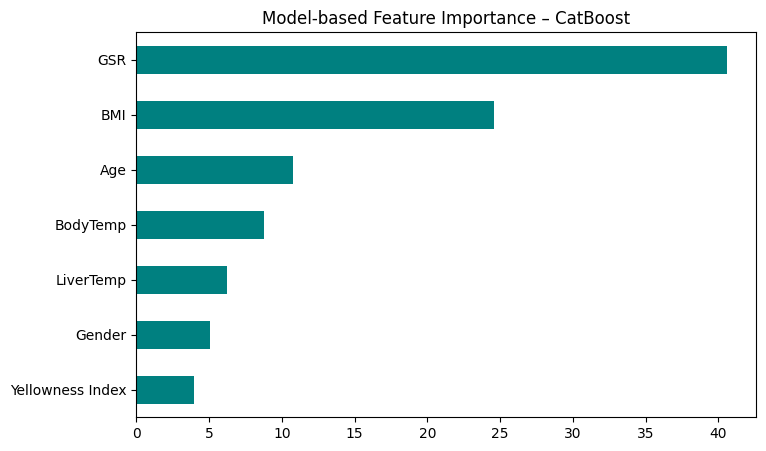

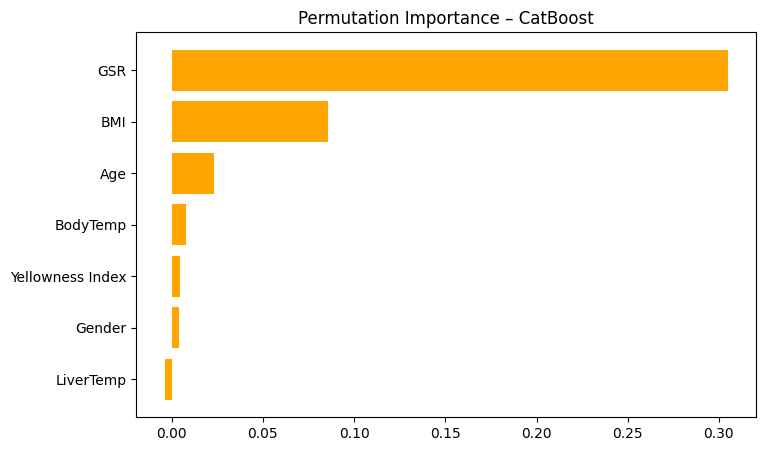

Generating SHAP for CatBoost...


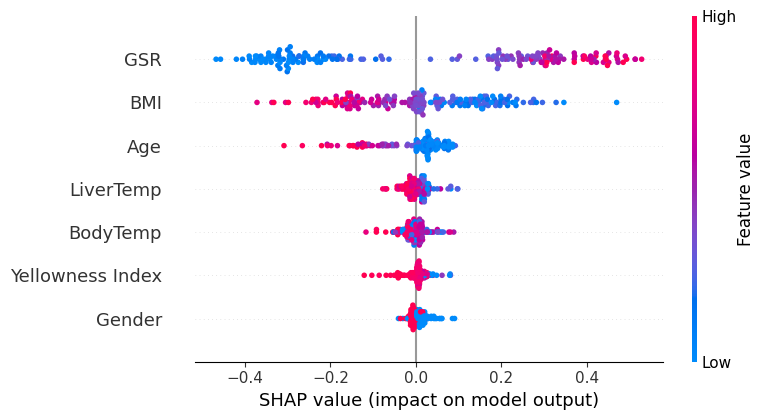

In [16]:
for name, model in best_estimators.items():
    print(f"\n🔍 Feature Importance – {name}")

    # (1) Model-based (Tree-based models)
    if hasattr(model, "feature_importances_"):
        plt.figure(figsize=(8, 5))
        feat_imp = pd.Series(model.feature_importances_, index=X.columns)
        feat_imp.sort_values().plot(kind="barh", color="teal")
        plt.title(f"Model-based Feature Importance – {name}")
        plt.show()

    # (2) Permutation Importance (All models)
    perm_imp = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)
    plt.figure(figsize=(8, 5))
    sorted_idx = perm_imp.importances_mean.argsort()
    plt.barh(np.array(X.columns)[sorted_idx], perm_imp.importances_mean[sorted_idx], color="orange")
    plt.title(f"Permutation Importance – {name}")
    plt.show()

    # SHAP
    print(f"Generating SHAP for {name}...")
    explainer = shap.Explainer(model.predict_proba, X_train)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values[:, :, 1], features=X_test, feature_names=X.columns, show=True)

In [17]:
import joblib
import os

drive_base_path = "/content/drive/My Drive/"
model_dir = os.path.join(drive_base_path, "LiverGuardDeploy")
os.makedirs(model_dir, exist_ok=True)

joblib.dump(stacked_model, os.path.join(model_dir, "stacked_model.pkl"))
joblib.dump(voting_model, os.path.join(model_dir, "voting_model.pkl"))
joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))

print(f"✅ Models and scaler saved at: {model_dir}")

✅ Models and scaler saved at: /content/drive/My Drive/LiverGuardDeploy


In [19]:
def preprocess_sensor_input():
    print("\nEnter Real-Time Sensor Data:")

    try:
        age = int(input("Age: "))
        gender = input("Gender (Male/Female): ").strip().capitalize()
        r = float(input("Red Value (R): "))
        g = float(input("Green Value (G): "))
        b = float(input("Blue Value (B): "))
        c = float(input("Intensity value (C): "))
        body_temp = float(input("Body Temperature (°C): "))
        liver_temp = float(input("Liver Temperature (°C): "))
        gsr = float(input("GSR: "))
        bmi = float(input("BMI: "))

        gender_val = 1.0 if gender.lower() == "male" else 0.0

        input_df = pd.DataFrame([{
            "Age": age,
            "Gender": gender_val,
            "R": r,
            "G": g,
            "B": b,
            "C": c,
            "BodyTemp": body_temp,
            "LiverTemp": liver_temp,
            "GSR": gsr,
            "BMI": bmi,
        }])

        # ---- Yellowness Index Calculation ---- #
        R, G, B, C = input_df["R"].astype(float), input_df["G"].astype(float), input_df["B"].astype(float), input_df["C"].astype(float)

        rgb = np.stack([R, G, B], axis=1)
        C_array = C.to_numpy().reshape(-1, 1)
        rgb_norm = rgb / np.clip(C_array, 1e-6, None)
        gray_world_avg_input = np.mean(rgb_norm, axis=0)
        rgb_balanced = np.clip(rgb_norm / (gray_world_avg_input + 1e-6), 0, 1)
        gamma = 2.2
        rgb_linear = np.power(rgb_balanced, gamma)

        M_sRGB_D65 = np.array([
            [0.4124564, 0.3575761, 0.1804375],
            [0.2126729, 0.7151522, 0.0721750],
            [0.0193339, 0.1191920, 0.9503041]
        ])
        xyz = rgb_linear @ M_sRGB_D65.T
        X_coord, Y_coord, Z_coord = xyz[:, 0], xyz[:, 1], xyz[:, 2]
        Cx, Cz = 1.2769, 1.0592
        YI_raw = 100 * (Cx * X_coord - Cz * Z_coord) / np.clip(Y_coord, 1e-6, None)
        yi_min = YI_raw.min()
        yi_max = YI_raw.max()
        yellowness_index = (YI_raw - yi_min) / (yi_max - yi_min + 1e-6)
        input_df["Yellowness Index"] = yellowness_index

        input_df.drop(["R", "G", "B", "C"], axis=1, inplace=True)
        input_scaled = scaler.transform(input_df)

        return input_scaled
    except Exception as e:
        print(f"❌ Error in input or processing: {e}")
        return None

def classify_patient(model_type="stacked"):

    processed = preprocess_sensor_input()
    if processed is None:
        print("❌ Prediction aborted due to preprocessing error.")
        return

    try:
        if model_type == "stacked":
            pred = stacked_model.predict(processed)[0]
        elif model_type == "voting":
            pred = voting_model.predict(processed)[0]
        else:
            print("❌ Invalid model type. Use 'stacked' or 'voting'.")
            return
        if pred == 0:
            result = "Healthy"
        elif pred == 1:
            result = "Unhealthy"
        else:
            result = f"Unknown prediction: {pred}"

        print(f"\n🧠 Final Diagnosis using {model_type.title()} Model: {result}")

    except Exception as e:
        print(f"❌ Error during model prediction: {e}")

classify_patient(model_type="stacked")


Enter Real-Time Sensor Data:
Age: 9
Gender (Male/Female): male
Red Value (R): 67
Green Value (G): 90
Blue Value (B): 8
Intensity value (C): 89
Body Temperature (°C): 90
Liver Temperature (°C): 9
GSR: 0
BMI: 8

🧠 Final Diagnosis using Stacked Model: Unhealthy
